In [17]:
"""
We need this cell for reasons. . . .
"""

import  scipy.signal.signaltools
%matplotlib notebook

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import dtscalibration

import os
import warnings

warnings.simplefilter('ignore')  # Hide warnings to avoid clutter in the notebook

from dtscalibration import suggest_cable_shift_double_ended
from dtscalibration import read_silixa_files
from matplotlib import pyplot as plt
import numpy as np
from dtscalibration import shift_double_ended

from heat import *

import numpy as np


%matplotlib inline

3 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3553 points along the cable
The measurement is double ended
Reading the data from disk
I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
<xarray.DataArray 'x' (x: 2471)>
array([1.33000e-01, 3.88000e-01, 6.42000e-01, ..., 6.27497e+02, 6.27751e+02,
       6.28006e+02])
Coordinates:
  * x        (x) float64 0.133 0.388 0.642 0.896 ... 627.2 627.5 627.8 628.0
Attributes:
    name:              distance
    description:       Length along fiber
    long_description:  Starting at connector of forward channel
    units:             m 


 <xarray.DataArray 'x' (x: 2469)>
array([1.33000e-01, 3.88000e-01, 6.42000e-01, ..., 6.26989e+02, 6.27243e+02,
       6.27497e+02])
Coordinates:
  * x        (x) float64 0.133 0.388 0.642 0.896 ... 626.7 627.0 627.2 62

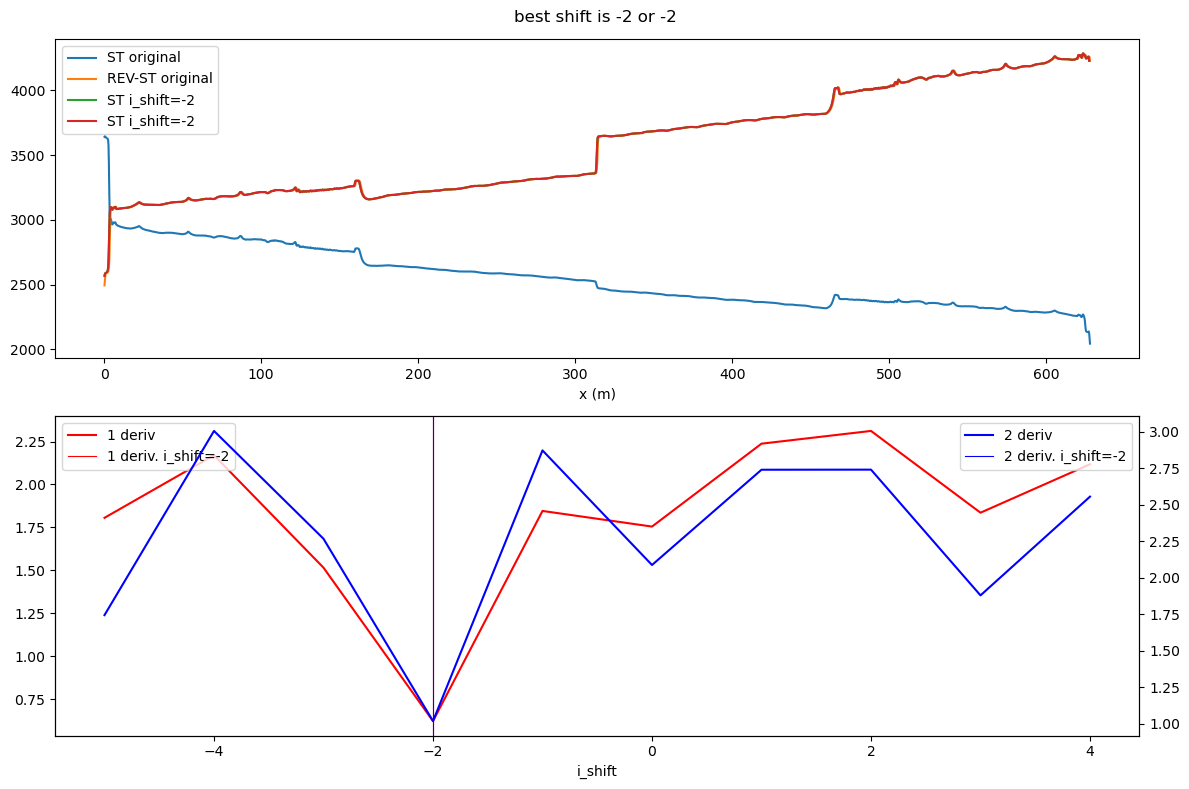

In [3]:
filepath = ''

ds_ = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds = ds_.sel(x=slice(0, 628.2))  # only calibrate parts of the fiber


sections = {
    'probe1Temperature': [slice(130., 158.)],  # temp isolator
    }
ds.sections = sections

suggested_shift = suggest_cable_shift_double_ended(
    ds,
    np.arange(-5, 5),
    plot_result=True,
    figsize=(12,8))

ds_restored = shift_double_ended(ds, suggested_shift[0])

print(ds.x, 3*'\n', ds_restored.x)

matching_sections = [
    (slice(130., 158.), slice(470.5, 498.75), False)
]
sections = {
    'probe1Temperature': [slice(130., 158.), slice(470., 500.)]
    }
ds_.sections = sections
st_var, resid = ds.variance_stokes(st_label='st')
ast_var, _ = ds.variance_stokes(st_label='ast')
rst_var, _ = ds.variance_stokes(st_label='rst')
rast_var, _ = ds.variance_stokes(st_label='rast')

ds.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    trans_att=[314.25],
    matching_sections=matching_sections,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

ds_.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')


# 1. DTS data messaging

<IPython.core.display.Javascript object>


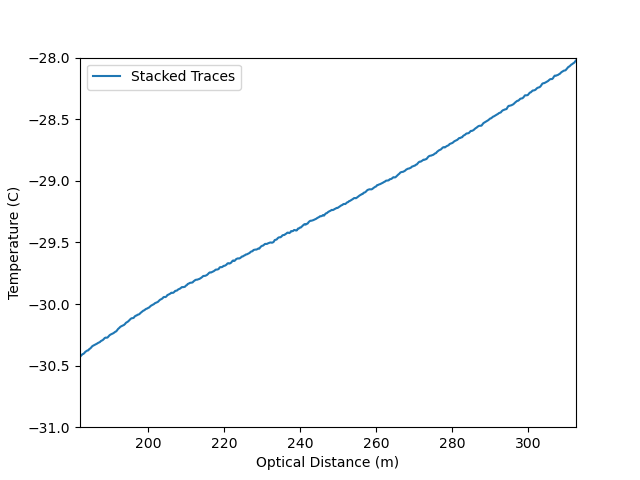

<IPython.core.display.Javascript object>


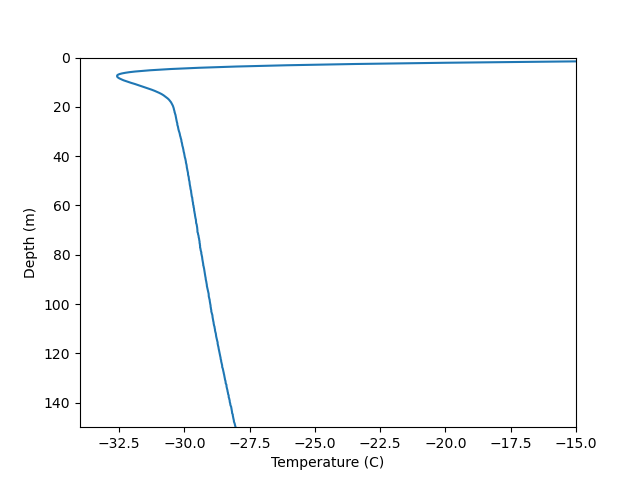

In [6]:
top_trend = 182 #optical distance (m), This is what we think the start of the long term signal is.
bottom_trend = 312.5 #optical distance (m), This is the bottom of the trend just above the warm bottom anomaly..
start_of_borehole = 162 #optical distance (m), Top of the borehole.

mean_sig1 = (ds.isel(time=0).tmpw + ds.isel(time=0).tmpw[::-1])/2
mean_sig2 = (ds.isel(time=1).tmpw + ds.isel(time=1).tmpw[::-1])/2
mean_sig3 = (ds.isel(time=2).tmpw + ds.isel(time=2).tmpw[::-1])/2

mean_tot = (mean_sig1 + mean_sig2 + mean_sig3) / 3


%matplotlib notebook

fig, ax = plt.subplots()
#plt.style.use('dark_background')
ax.plot(ds.x, mean_tot, label = 'Stacked Traces')
#ax.plot(ds.x, mean_tot[::-1], label = 'mean reversed')

ax.set_ylabel('Temperature (C)')
ax.set_xlabel('Optical Distance (m)')
plt.xlim([top_trend, bottom_trend])
plt.ylim([-31,-28])
plt.legend()

borehole_below_season = mean_tot.sel(x=slice(top_trend,bottom_trend))

fig, ax = plt.subplots()
plt.gca().invert_yaxis()
#plt.style.use('dark_background')
ax.plot(mean_tot, ds.x - start_of_borehole, label = 'Stacked Traces')
#ax.plot(ds.x, mean_tot[::-1], label = 'mean reversed')

ax.set_xlabel('Temperature (C)')
ax.set_ylabel('Depth (m)')
ax.set_ylim([150, 0])
plt.xlim([-34,-15])
plt.show()
#plt.legend()

In [45]:
#Parameters

tmax = 2023
tmin = 1023
zmax = bottom_trend - top_trend#150
dTdz = 0.02
nz = len(mean_tot.sel(x=slice(top_trend,bottom_trend)))
nt = 99
alpha = 43
accumulation = 0
x_vel = 0.2 #cm/yr
x_dis = x_vel * (tmax - tmin)
z_dis = 75 # 75 m drop in surface elevation
dry_adb = 10e-3 # C per m

## 1.1 We remove the linear fit from the signal which should leave just the climate variations.

43.48818763132378
-33.536986223221604


<IPython.core.display.Javascript object>


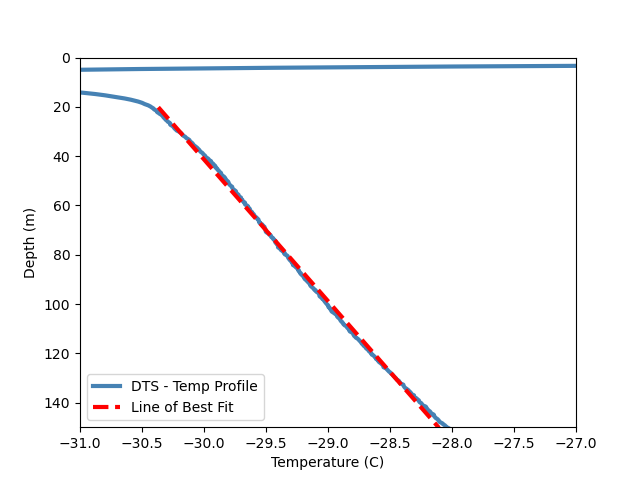

<IPython.core.display.Javascript object>


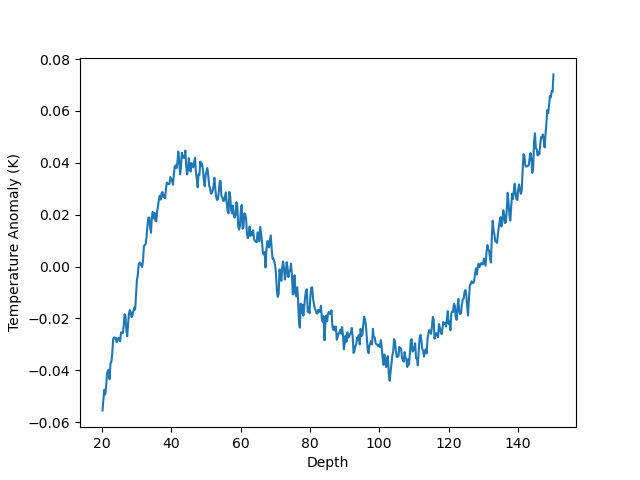

Text(0.5, 0, 'Depth')

In [46]:
#Geothermal flux from a linear fit

#Where do we want to start the linear best fit relatively to the top of what we think the trend is?

start_here = 0   # 0 is the start of the top of the trend

m,b = np.polyfit(mean_tot.sel(x=slice(top_trend+start_here,bottom_trend)).x, 
                 mean_tot.sel(x=slice(top_trend+start_here,bottom_trend)), 1)

Q_geo = m *2.5*1e3
print(Q_geo)
print(b)

x  = m*mean_tot.sel(x=slice(top_trend+start_here,bottom_trend)).x + b

y  = m*mean_tot.sel(x=slice(top_trend,bottom_trend)).x + b
anomaly = mean_tot.sel(x=slice(top_trend,bottom_trend)) - y

#plot the geothermal heat flux
%matplotlib notebook

fig, ax = plt.subplots()
plt.gca().invert_yaxis()
#plt.style.use('dark_background')
ax.plot(mean_tot, ds.x - start_of_borehole, label = 'DTS - Temp Profile', lw = 3, c='steelblue')
ax.plot(x, mean_tot.sel(x=slice(top_trend+start_here,bottom_trend)).x - start_of_borehole, label = 'Line of Best Fit', ls="--", lw = 3, c='red')
#ax.plot(ds.x, mean_tot[::-1], label = 'mean reversed')

ax.set_xlabel('Temperature (C)')
ax.set_ylabel('Depth (m)')
ax.set_ylim([150, 0])
ax.set_xlim([-31,-27])
plt.legend()

fig,ax = plt.subplots()
#ax.plot(anomaly.values)
ax.plot(mean_tot.sel(x=slice(top_trend+start_here,bottom_trend)).x - start_of_borehole,anomaly)
ax.set_ylabel('Temperature Anomaly (K)')
ax.set_xlabel('Depth')

## 1.2 Simulated surface temperature and borehole temp from a horizontally advected, constant thickness, column of ice

In [90]:
this_t_surf = np.linspace(0,z_dis,nt) * dry_adb 

In [91]:
U,t,z = heat(this_t_surf,
     tmax = tmax,
     tmin = tmin,
     zmax = zmax,
     dTdz = dTdz,
     nz = nz,
     nt = nt,
     alpha = alpha,
     accumulation = accumulation)

<IPython.core.display.Javascript object>


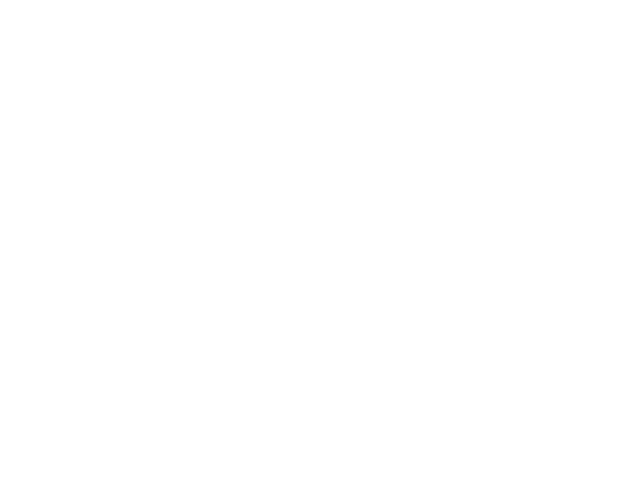

In [92]:
from scipy.signal import detrend
plt.subplots()
vm=0.01
c=plt.pcolor(t,z,detrend(U),cmap='seismic')
# c=plt.pcolor(t,z,A,vmin=-vm,vmax=vm,cmap='seismic')
plt.colorbar(c)
plt.ylim([zmax,0])
plt.xlabel('Year')
plt.ylabel('Depth')
plt.show()

<IPython.core.display.Javascript object>


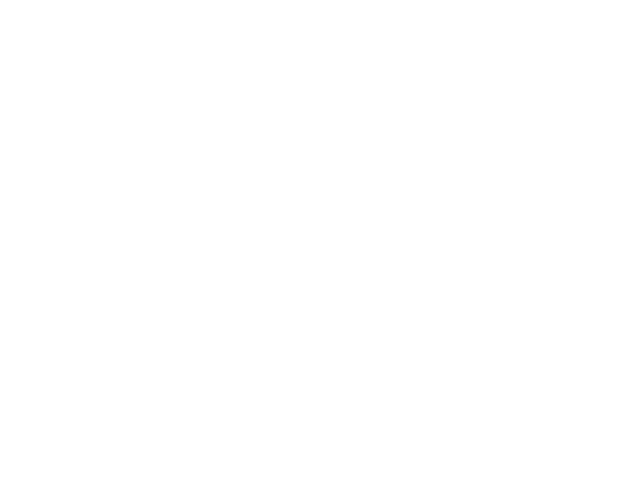

In [93]:
plt.subplots()
vm=0.01
plt.plot(z,detrend(U[:,-1], axis=0))
# c=plt.pcolor(t,z,A,vmin=-vm,vmax=vm,cmap='seismic')

<IPython.core.display.Javascript object>


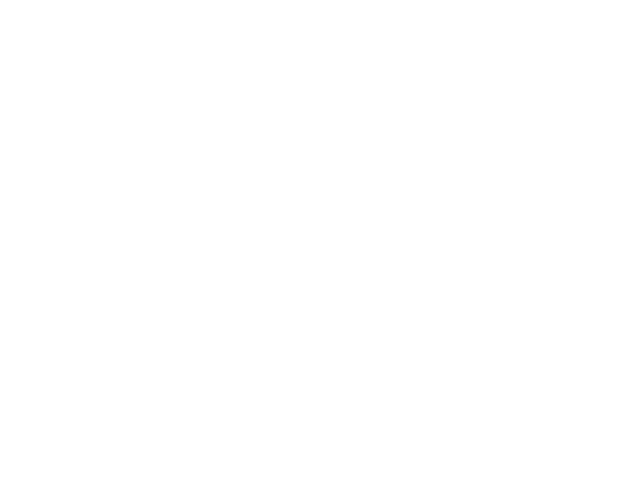

In [94]:
advection_removed = anomaly.values - detrend(U[:,-1])[:-1]
plt.subplots()

plt.plot(advection_removed)
plt.plot(anomaly.values)

In [97]:
# Import the ice temperature model and relevant constants
from iceotherm.lib.numerical_model import ice_temperature
from iceotherm.lib.analytical_solutions import Robin_T, Rezvan_T, Meyer_T, Perol_T
from iceotherm.lib.ice_properties import conductivity, heat_capacity, rate_factor
from iceotherm.lib.constants import constants
const = constants()

<IPython.core.display.Javascript object>


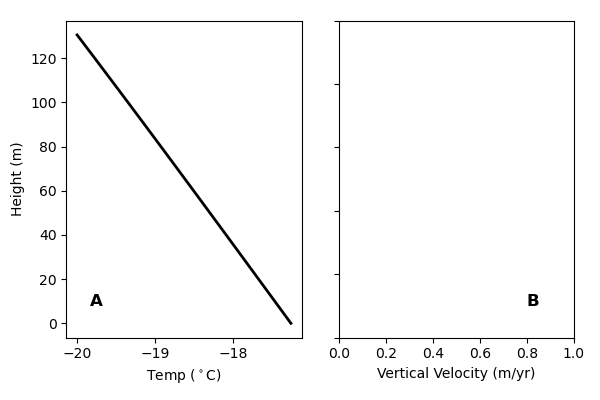

Running model to steady state


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

KeyboardInterrupt: 

In [117]:
# Initialize the model class
m = ice_temperature(nz=100, Ts= -20,H=zmax, adot=-2e-2, qgeo=43.6e-3, dS=45)
#m = ice_temperature(nz=200)
m.initial_conditions()
m.source_terms()
m.stencil(dt=1.*const.spy)

# Initialize the figure
plt.figure(figsize=(6,4))
ax1 = plt.subplot(121)
ax1.set_ylabel('Height (m)')
ax1.set_xlabel('Temp ($^\circ$C)')
plt.text(.1,.1,'A',transform=ax1.transAxes,fontweight='bold',fontsize=12)
ax2 = plt.subplot(122)
ax2.tick_params(labelleft=False)
ax2.set_xlabel('Vertical Velocity (m/yr)')
plt.text(.8,.1,'B',transform=ax2.transAxes,fontweight='bold',fontsize=12)
plt.tight_layout()

# Run and plot the analytical solution
TR,Mrate = Robin_T(m)
ax1.plot(TR,m.z,'k-',lw=2,label='Robin (1955)')
# Run and plot the numerical solution in the case of a linear vertical velocity profile (p=1000)
m.numerical_to_steady_state()
ax1.plot(m.T,m.z,'--',c='indianred',label='Numerical\np=1000')
# Plot the vertical velocity profile
ax2.plot(m.v_z*const.spy,m.z,'--',c='indianred')

# As a comparison, use a more divide-like vertical velocity profile
m.p = 5.
m.initial_conditions()
m.source_terms()
m.stencil(dt=1.*const.spy)

# Run and plot the numerical solution
m.numerical_to_steady_state()
ax1.plot(m.T,m.z,'-',c='indianred',label='p=%.0f'%m.p)
ax2.plot(m.v_z*const.spy,m.z,'-',c='indianred')

In [ ]:
m.T